# Mirror Descent Convergence Analysis

This notebook visualizes how the mirror descent algorithm converges during optimization of the Wasserstein distance computation.

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from test_utils import test_sparse_mirror_descent, test_ws_distance, dia_matrix
from concurrent.futures import ProcessPoolExecutor, as_completed
import multiprocessing
from tqdm import tqdm



## Run Mirror Descent Optimization

First, we'll run the optimization with different parameters and collect the convergence data.

In [36]:
# Define parameters
N = 1000        # Number of features
C = 20         # Bandwidth parameter
p = 0.4       # Mixing ratio
reg = 1.5    # KL regularization
reg_a = 100     # Source marginal regularization 
reg_b = 2    # Target marginal regularization
max_iter = 1000  # Maximum iterations
step_size = 0.001  # Learning rate
gamma = 1.0 - 20.0 / max_iter

# Run optimization
_, log_data = test_sparse_mirror_descent(
    N, C, p, reg, reg_a, reg_b, 
    max_iter=max_iter, 
    step_size=step_size, 
    debug=False,
    gamma=gamma,
)

print(f"Optimization completed in {log_data.get('iterations', 'unknown')} iterations")
print(f"Converged: {log_data.get('convergence', False)}")
print(f"Final objective value: {log_data.get('final_distance', 'unknown')}")

Optimization completed in 428 iterations
Converged: True
Final objective value: 0.08192445754967582


## Visualize Convergence


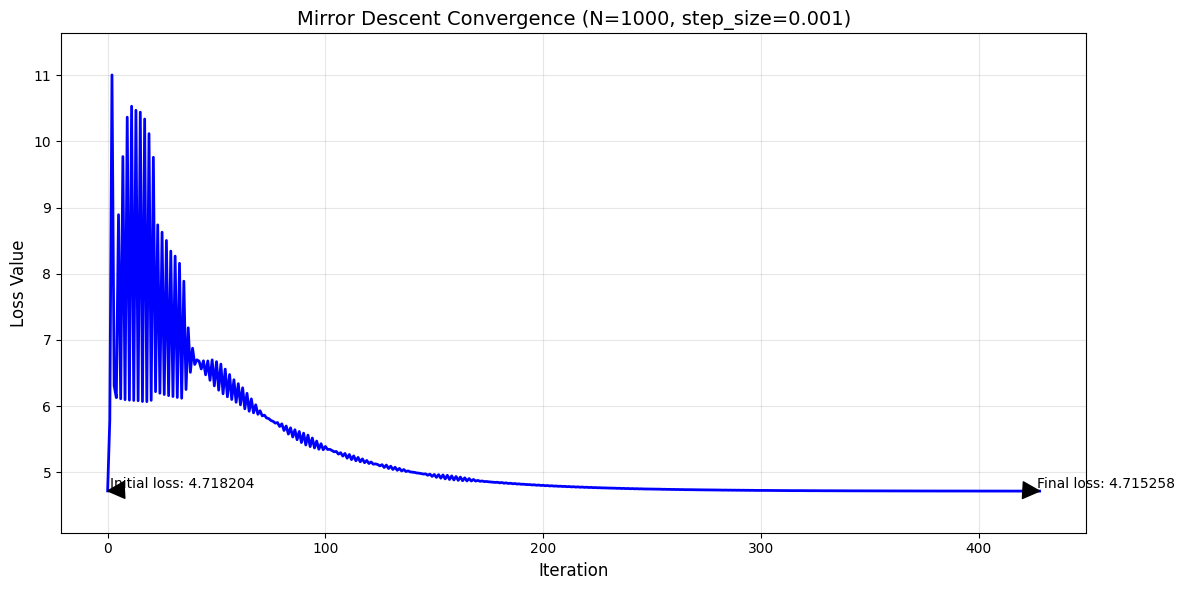

In [37]:
# Extract loss values from log
losses = log_data.get('loss', [])
iterations = range(len(losses))

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(iterations, losses, 'b-', linewidth=2)
plt.grid(True, alpha=0.3)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Loss Value', fontsize=12)
plt.title(f'Mirror Descent Convergence (N={N}, step_size={step_size})', fontsize=14)

# Set y-axis limits with some margin to avoid extreme stretching
if len(losses) > 0:
    min_loss = min(losses)
    max_loss = max(losses)
    if min_loss != max_loss:
        y_margin = 0.1 * (max_loss - min_loss)
        plt.ylim(min_loss - y_margin, max_loss + y_margin)
    else:
        plt.ylim(min_loss - 1, max_loss + 1)

# Add annotation for final loss
if len(losses) > 1:
    plt.annotate(f'Final loss: {losses[-1]:.6f}', 
                xy=(iterations[-1], losses[-1]),
                xytext=(iterations[-1]-1, losses[-1]*1.01),
                arrowprops=dict(facecolor='black', shrink=0.05, width=1.5))

# Add initial loss annotation
if len(losses) > 0:
    plt.annotate(f'Initial loss: {losses[0]:.6f}', 
                xy=(0, losses[0]),
                xytext=(1, losses[0]*1.01),
                arrowprops=dict(facecolor='black', shrink=0.05, width=1.5))

plt.tight_layout()
plt.show()


## Function Behavior Analysis

Let's explore how the function behaves for different parameter values 

Starting parallel analysis of function behavior...


Analyzing function behavior: 100%|██████████| 30/30 [01:17<00:00,  2.60s/it]


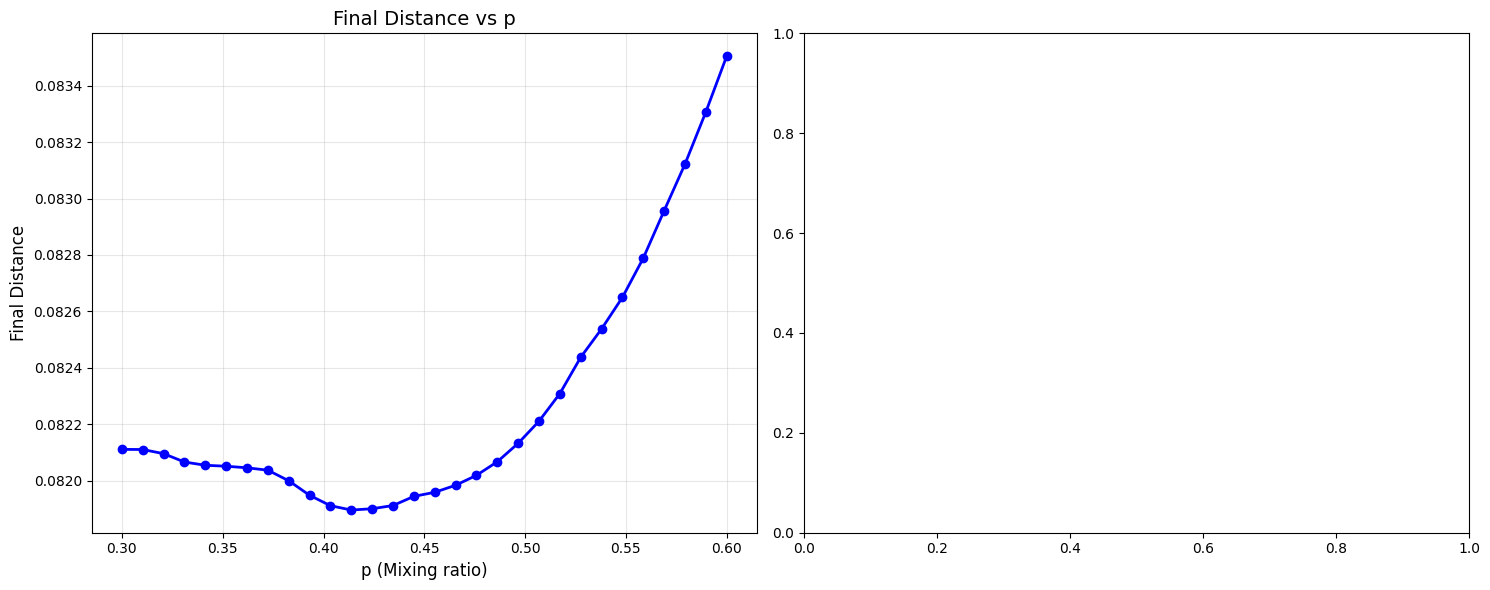


Summary for p values from 0.30 to 0.60:
Final Distance - Min: 0.081896, Max: 0.083505


In [38]:
M = 2 * N
offsets = np.arange(-C + 1, C)
matrix_shape = (M, M)
test_values = np.linspace(0.3, 0.6, 30)
final_distances_map = {}

def process_wrapper(args):
    """
    Wrapper function to execute the mirror descent test in a separate process.
    """
    test_p, N, C, reg, reg_a, reg_b, max_iter, step_size, gamma = args
    
    # Run the optimization without warmstart since each process is independent.
    # The test function will create a basic warmstart internally.
    _, log = test_sparse_mirror_descent(
        N=N,
        C=C,
        p=test_p,
        reg=reg,
        reg_m1=reg_a,
        reg_m2=reg_b,
        max_iter=max_iter,
        step_size=step_size,
        debug=False,  # Disable debug for cleaner output in parallel execution
        warmstart=None,
        gamma=gamma
    )
    
    # Return the value of p and the final distance
    return test_p, log["final_distance"]

# Prepare arguments for each parallel task
args_list = [(p, N, C, reg, reg_a, reg_b, max_iter, step_size, gamma) for p in test_values]

# Execute the tests in parallel using a process pool
print("Starting parallel analysis of function behavior...")
with ProcessPoolExecutor(max_workers=multiprocessing.cpu_count()) as executor:
    # Use as_completed to process results as they become available
    futures = [executor.submit(process_wrapper, arg) for arg in args_list]
    
    # Display a progress bar for the parallel execution
    for future in tqdm(as_completed(futures), total=len(test_values), desc="Analyzing function behavior"):
        p_res, final_distance = future.result()
        final_distances_map[p_res] = final_distance

# Sort the results by p for consistent plotting
sorted_p = sorted(final_distances_map.keys())
final_distances = [final_distances_map[p] for p in sorted_p]

# Create visualization of the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot the final distance as a function of p
ax1.plot(sorted_p, final_distances, 'bo-', linewidth=2, markersize=6)
ax1.grid(True, alpha=0.3)
ax1.set_xlabel('p (Mixing ratio)', fontsize=12)
ax1.set_ylabel('Final Distance', fontsize=12)
ax1.set_title('Final Distance vs p', fontsize=14)


plt.tight_layout()
plt.show()

# Print summary statistics of the results
print(f"\nSummary for p values from {min(sorted_p):.2f} to {max(sorted_p):.2f}:")
print(f"Final Distance - Min: {min(final_distances):.6f}, Max: {max(final_distances):.6f}")

# WS distance for comparison

Starting parallel analysis of ws_distance...


Analyzing ws_distance: 100%|██████████| 50/50 [00:03<00:00, 13.42it/s]


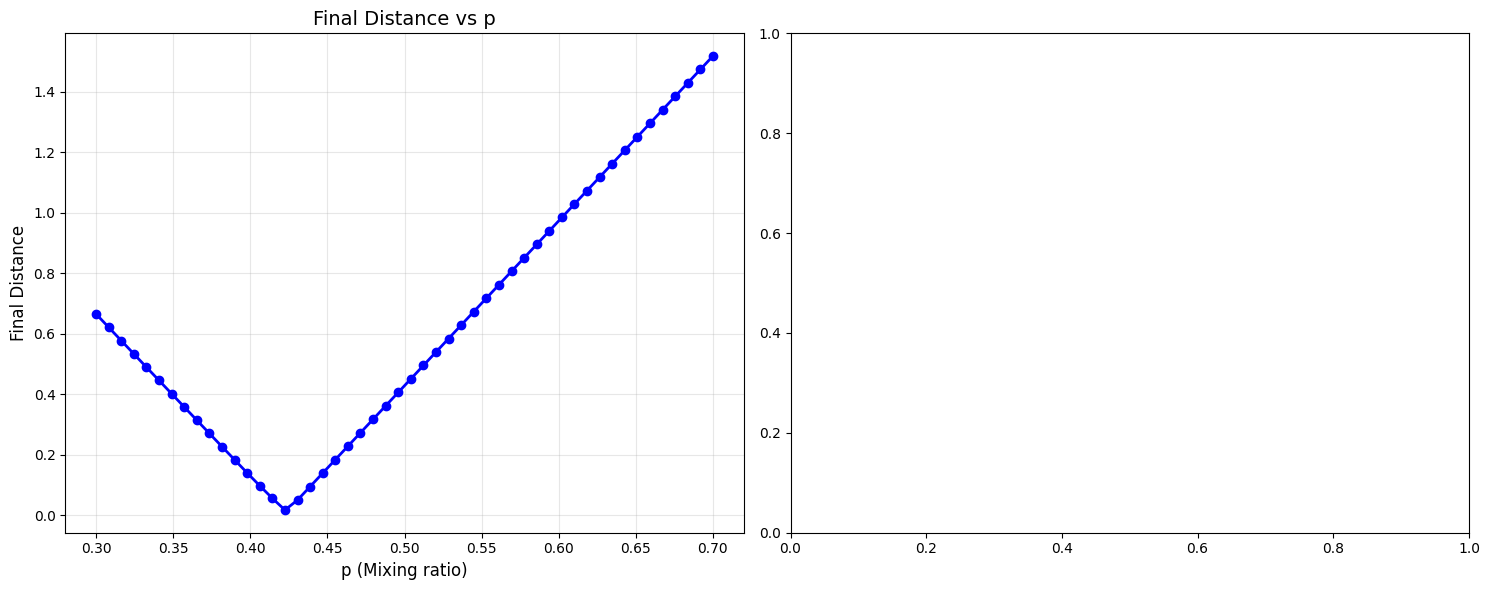


Summary for p values from 0.30 to 0.70:
Final Distance - Min: 0.017979, Max: 1.517732


In [39]:
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm

def process_wrapper_ws(args):
    """
    Wrapper function to execute the ws_distance test in a separate process.
    """
    test_p, N, C, reg_a, reg_b, max_iter, step_size = args
    
    # Run the optimization
    distance = test_ws_distance(
        N,
        C,
        test_p,
        0.01,
        reg_a,
        reg_b,
        max_iter=max_iter,
        step_size=step_size,
        debug=False, # Disable debug for cleaner output
    )
    
    return test_p, distance

# Test function behavior for different p values between 0.3 and 0.7

test_values = np.linspace(0.3, 0.7, 50)
final_distances_map_ws = {}

# Prepare arguments for each parallel task
args_list_ws = [(p, N, C, reg_a, reg_b, max_iter, step_size) for p in test_values]

print("Starting parallel analysis of ws_distance...")
with ProcessPoolExecutor(max_workers=multiprocessing.cpu_count()) as executor:
    futures = [executor.submit(process_wrapper_ws, arg) for arg in args_list_ws]
    
    for future in tqdm(as_completed(futures), total=len(test_values), desc="Analyzing ws_distance"):
        p, distance = future.result()
        final_distances_map_ws[p] = distance

# Sort the results by p for consistent plotting
sorted_p_ws = sorted(final_distances_map_ws.keys())
final_distances_ws = [final_distances_map_ws[p] for p in sorted_p_ws]


# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot final distances
ax1.plot(sorted_p_ws, final_distances_ws, "bo-", linewidth=2, markersize=6)
ax1.grid(True, alpha=0.3)
ax1.set_xlabel("p (Mixing ratio)", fontsize=12)
ax1.set_ylabel("Final Distance", fontsize=12)
ax1.set_title("Final Distance vs p", fontsize=14)


plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nSummary for p values from {min(sorted_p_ws):.2f} to {max(sorted_p_ws):.2f}:")
print(
    f"Final Distance - Min: {min(final_distances_ws):.6f}, Max: {max(final_distances_ws):.6f}"
)
